# Neural Network for the Higgs data decay

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import  train_test_split 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns

/Users/hal9000/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hal9000/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hal9000/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/hal9000/opt/anaconda3/lib/python3.7/

### a) Let's start first with the data set where all the unphysical values, i.e. the -999 values, are set to NaN

In [2]:
# Load the data
nan_data=pd.read_csv('DataFiles/nan_data.csv')

In [3]:
nan_data.head()
#Checking the replacement of the unphysical -999 values was successful. 
#Let's notice that these values were replaced by NaN

,Unnamed: 0,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,1,100001,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,...,0.725,1.158,NaN,NaN,NaN,46.226,0.681042,b,t,2.233584
2,2,100002,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,...,2.053,-2.028,NaN,NaN,NaN,44.251,0.715742,b,t,2.347389
3,3,100003,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,...,NaN,NaN,NaN,NaN,NaN,-0.000,1.660654,b,t,5.446378
4,4,100004,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,...,NaN,NaN,NaN,NaN,NaN,0.000,1.904263,b,t,6.245333


Since not all features all physically relevant, we need to drop them before continuing. In particular, the columns we will drop are

In [4]:
todrop = ['Unnamed: 0','EventId','Weight','KaggleWeight', 'PRI_jet_leading_phi', 'PRI_jet_subleading_phi', 'PRI_met_phi', 'PRI_lep_phi', 'PRI_tau_phi' ]

In [5]:
#Dropping spoureous and unphysical variables
nan_data=nan_data.drop(todrop,axis=1)

In [6]:
nan_data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_all_pt,Label,KaggleSet
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,16.824,258.733,2.0,67.435,2.150,46.062,1.24,113.497,s,t
1,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,...,44.704,164.546,1.0,46.226,0.725,NaN,NaN,46.226,b,t
2,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,...,54.283,260.414,1.0,44.251,2.053,NaN,NaN,44.251,b,t
3,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,...,31.082,86.062,0.0,NaN,NaN,NaN,NaN,-0.000,b,t
4,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,...,2.723,53.131,0.0,NaN,NaN,NaN,NaN,0.000,b,t


Splitting into jets

In [7]:
jets_0 = nan_data[nan_data['PRI_jet_num']==0]
jets_1 = nan_data[nan_data['PRI_jet_num']==1]
jets_2 = nan_data[nan_data['PRI_jet_num']==2]
jets_3 = nan_data[nan_data['PRI_jet_num']==3]

jets_0.shape, jets_1.shape, jets_2.shape, jets_3.shape

((186126, 27), (143969, 27), (93693, 27), (41446, 27))

In [8]:
for jet, cur_set in enumerate([jets_0, jets_1, jets_2, jets_3]):
    print("\n")
    print("Features in the dataset with jet=", jet, "that have a NaN value")
    print("\n")
    for col in range(len(cur_set.columns)):
        print("{:<30s}{:>4d}".format(nan_data.columns[col],cur_set.iloc[:, col].isnull().sum()))



Features in the dataset with jet= 0 that have a NaN value


DER_mass_MMC                  48700
DER_mass_transverse_met_lep      0
DER_mass_vis                     0
DER_pt_h                         0
DER_deltaeta_jet_jet          186126
DER_mass_jet_jet              186126
DER_prodeta_jet_jet           186126
DER_deltar_tau_lep               0
DER_pt_tot                       0
DER_sum_pt                       0
DER_pt_ratio_lep_tau             0
DER_met_phi_centrality           0
DER_lep_eta_centrality        186126
PRI_tau_pt                       0
PRI_tau_eta                      0
PRI_lep_pt                       0
PRI_lep_eta                      0
PRI_met                          0
PRI_met_sumet                    0
PRI_jet_num                      0
PRI_jet_leading_pt            186126
PRI_jet_leading_eta           186126
PRI_jet_subleading_pt         186126
PRI_jet_subleading_eta        186126
PRI_jet_all_pt                   0
Label                            0
KaggleSet  

Since some columns are still composed entirely by -999 (i.e. NaN) values, we will drop them

In [9]:
for jet, cur_set  in enumerate([jets_0, jets_1, jets_2, jets_3]):
    print("\n")
    print("Features in the dataset with jet=", jet, "that were dropped since they only have Nan values")
    print("\n")
    print("Current shape:",cur_set.shape)
    delete=[]
    for col in range(0,24):
         if cur_set.iloc[:, col].isnull().sum()==len(cur_set): #if the entire column is composed of -999 values we drop it
            delete.append(cur_set.columns[col]) #save the column names
            print(cur_set.columns[col])
    cur_set.drop(columns=delete, inplace= True) #drop the columns in the current dataframe
    print("After shape:",cur_set.shape)



Features in the dataset with jet= 0 that were dropped since they only have Nan values


Current shape: (186126, 27)
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_lep_eta_centrality
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_subleading_pt
PRI_jet_subleading_eta
After shape: (186126, 19)


Features in the dataset with jet= 1 that were dropped since they only have Nan values


Current shape: (143969, 27)
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_lep_eta_centrality
PRI_jet_subleading_pt
PRI_jet_subleading_eta
After shape: (143969, 21)


Features in the dataset with jet= 2 that were dropped since they only have Nan values


Current shape: (93693, 27)
After shape: (93693, 27)


Features in the dataset with jet= 3 that were dropped since they only have Nan values


Current shape: (41446, 27)
After shape: (41446, 27)


/Users/hal9000/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
for jet, cur_set in enumerate([jets_0, jets_1, jets_2, jets_3]):
    print("\n")
    print("Features in the dataset with jet=", jet, "that have a NaN value")
    print("\n")
    for col in range(len(cur_set.columns)):
        print("{:<30s}{:>4d}".format(nan_data.columns[col],cur_set.iloc[:, col].isnull().sum()))



Features in the dataset with jet= 0 that have a NaN value


DER_mass_MMC                  48700
DER_mass_transverse_met_lep      0
DER_mass_vis                     0
DER_pt_h                         0
DER_deltaeta_jet_jet             0
DER_mass_jet_jet                 0
DER_prodeta_jet_jet              0
DER_deltar_tau_lep               0
DER_pt_tot                       0
DER_sum_pt                       0
DER_pt_ratio_lep_tau             0
DER_met_phi_centrality           0
DER_lep_eta_centrality           0
PRI_tau_pt                       0
PRI_tau_eta                      0
PRI_lep_pt                       0
PRI_lep_eta                      0
PRI_met                          0
PRI_met_sumet                    0


Features in the dataset with jet= 1 that have a NaN value


DER_mass_MMC                  14135
DER_mass_transverse_met_lep      0
DER_mass_vis                     0
DER_pt_h                         0
DER_deltaeta_jet_jet             0
DER_mass_jet_jet                 0

Scikit-learn data do not support NaN values. There are several strategies to follow, but the easiest is just to remove every row that contains a NaN

In [11]:
for jet, cur_set  in enumerate([jets_0, jets_1, jets_2, jets_3]):
    print("\n")
    print("The number of features in the dataset with jet=", jet, "was reduced from")
    print("\n")
    print(cur_set.shape)
    cur_set.dropna(inplace=True) #Drop the rows where at least one element is missing.
    print("to")
    print(cur_set.shape)



The number of features in the dataset with jet= 0 was reduced from


(186126, 19)
to
(137426, 19)


The number of features in the dataset with jet= 1 was reduced from


(143969, 21)
to
(129834, 21)


The number of features in the dataset with jet= 2 was reduced from


(93693, 27)
to
(88143, 27)


The number of features in the dataset with jet= 3 was reduced from


(41446, 27)
to
(38722, 27)


/Users/hal9000/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hal9000/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hal9000/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hal9000/opt/anaconda3/lib/python3.7/site-pack

Verifying that there are no NaN values anymore

In [12]:
for jet, cur_set in enumerate([jets_0, jets_1, jets_2, jets_3]):
    print("\n")
    print("Features in the dataset with jet=", jet, "that have a NaN value")
    print("\n")
    for col in range(len(cur_set.columns)):
        print("{:<30s}{:>4d}".format(nan_data.columns[col],cur_set.iloc[:, col].isnull().sum()))



Features in the dataset with jet= 0 that have a NaN value


DER_mass_MMC                     0
DER_mass_transverse_met_lep      0
DER_mass_vis                     0
DER_pt_h                         0
DER_deltaeta_jet_jet             0
DER_mass_jet_jet                 0
DER_prodeta_jet_jet              0
DER_deltar_tau_lep               0
DER_pt_tot                       0
DER_sum_pt                       0
DER_pt_ratio_lep_tau             0
DER_met_phi_centrality           0
DER_lep_eta_centrality           0
PRI_tau_pt                       0
PRI_tau_eta                      0
PRI_lep_pt                       0
PRI_lep_eta                      0
PRI_met                          0
PRI_met_sumet                    0


Features in the dataset with jet= 1 that have a NaN value


DER_mass_MMC                     0
DER_mass_transverse_met_lep      0
DER_mass_vis                     0
DER_pt_h                         0
DER_deltaeta_jet_jet             0
DER_mass_jet_jet                 0
D

Creating test and training arrays for each jet, and removing the Labels.

In [13]:
jets_0_train = jets_0[jets_0['KaggleSet']=='t']
jets_0_test = jets_0[jets_0['KaggleSet']=='b']
jets_1_train = jets_1[jets_1['KaggleSet']=='t']
jets_1_test = jets_1[jets_1['KaggleSet']=='b']

jets_2_train = jets_2[jets_2['KaggleSet']=='t']
jets_2_test = jets_2[jets_2['KaggleSet']=='b']

jets_3_train = jets_3[jets_3['KaggleSet']=='t']
jets_3_test = jets_3[jets_3['KaggleSet']=='b']

In [14]:
def bs_bool(x): # This function changes b and s by boolean values
    y=np.zeros(len(x))
    for i in range(len(x)):
        if x[i]=='s':
            y[i]=1
        else:
            y[i]=0
    return y

In [15]:
Y_0_train = bs_bool(np.array(jets_0_train['Label']))
Y_0_test = bs_bool(np.array(jets_0_test['Label']))

Y_1_train = bs_bool(np.array(jets_1_train['Label']))
Y_1_test = bs_bool(np.array(jets_1_test['Label']))

Y_2_train = bs_bool(np.array(jets_2_train['Label']))
Y_2_test = bs_bool(np.array(jets_2_test['Label']))

Y_3_train = bs_bool(np.array(jets_3_train['Label']))
Y_3_test = bs_bool(np.array(jets_3_test['Label']))

In [16]:
jets_0_train = np.array(jets_0_train.drop(['Label','KaggleSet'], axis=1))
jets_0_test = np.array(jets_0_test.drop(['Label','KaggleSet'], axis=1))

jets_1_train = np.array(jets_1_train.drop(['Label','KaggleSet'], axis=1))
jets_1_test = np.array(jets_1_test.drop(['Label','KaggleSet'], axis=1))

jets_2_train = np.array(jets_2_train.drop(['Label','KaggleSet'], axis=1))
jets_2_test = np.array(jets_2_test.drop(['Label','KaggleSet'], axis=1))

jets_3_train = np.array(jets_3_train.drop(['Label','KaggleSet'], axis=1))
jets_3_test = np.array(jets_3_test.drop(['Label','KaggleSet'], axis=1))

### NEURAL NETWORK

Before applying the method, we must scale our data.

In [17]:
scaler = StandardScaler() 


scaler.fit(jets_0_train)
jets_0_train_sc = scaler.transform(jets_0_train)
jets_0_test_sc=scaler.transform(jets_0_test)

scaler.fit(jets_1_train)
jets_1_train_sc = scaler.transform(jets_1_train)
jets_1_test_sc=scaler.transform(jets_1_test)

scaler.fit(jets_2_train)
jets_2_train_sc = scaler.transform(jets_2_train)
jets_2_test_sc=scaler.transform(jets_2_test)

scaler.fit(jets_3_train)
jets_3_train_sc = scaler.transform(jets_3_train)
jets_3_test_sc=scaler.transform(jets_3_test)

In [18]:
len(jets_0_train_sc[0]),len(jets_1_train_sc[0]),len(jets_2_train_sc[0]),len(jets_3_train_sc[0])

(17, 19, 25, 25)

Since every jet has a different number of features, we must create for each a neural network. In this we will consider a neural network 5 layers.

In [19]:
model_jets_0 = tf.keras.Sequential([
        keras.layers.Dense(units=30, input_shape=(len(jets_0_train_sc[0]),), activation='relu'), #units corresponds to the number of nodes
        keras.layers.Dense(units=1200, activation='relu'),
        keras.layers.Dense(units=200, activation='relu'),
        keras.layers.Dense(units=20, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax') #2 since we have two posssible outcomes
    ])

model_jets_1 = tf.keras.Sequential([
        keras.layers.Dense(units=30, input_shape=(len(jets_1_train_sc[0]),), activation='relu'), 
        keras.layers.Dense(units=1200, activation='relu'),
        keras.layers.Dense(units=200, activation='relu'),
        keras.layers.Dense(units=20, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax') 
    ])

model_jets_2 = tf.keras.Sequential([
        keras.layers.Dense(units=30, input_shape=(len(jets_2_train_sc[0]),), activation='relu'), 
        keras.layers.Dense(units=1200, activation='relu'),
        keras.layers.Dense(units=200, activation='relu'),
        keras.layers.Dense(units=20, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax') 
    ])

model_jets_3 = tf.keras.Sequential([
        keras.layers.Dense(units=30, input_shape=(len(jets_3_train_sc[0]),), activation='relu'), 
        keras.layers.Dense(units=1200, activation='relu'),
        keras.layers.Dense(units=200, activation='relu'),
        keras.layers.Dense(units=20, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax') 
    ])

model_jets_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                540       
_________________________________________________________________
dense_1 (Dense)              (None, 1200)              37200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               240200    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                4020      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 42        
Total params: 282,002
Trainable params: 282,002
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_jets_0.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #binary_crossentropy
                  metrics=['accuracy'])

model_jets_0.fit(jets_0_train_sc, Y_0_train,epochs=25, batch_size=32)

# The epochs represent the number of times the model goes throught the whole dataset
# The batch size is a number of samples processed before the model is updated.


# evaluate the keras model
_, accuracy = model_jets_0.evaluate(jets_0_test_sc, Y_0_test)
print('\n')
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/25
2306/2306 [==============================] - 5s 2ms/step - loss: 0.4435 - accuracy: 0.7962
Epoch 2/25
2306/2306 [==============================] - 5s 2ms/step - loss: 0.4126 - accuracy: 0.8127
Epoch 3/25
2306/2306 [==============================] - 5s 2ms/step - loss: 0.4040 - accuracy: 0.8174
Epoch 4/25
2306/2306 [==============================] - 5s 2ms/step - loss: 0.4055 - accuracy: 0.8154
Epoch 5/25
2306/2306 [==============================] - 5s 2ms/step - loss: 0.4034 - accuracy: 0.8158
Epoch 6/25
2306/2306 [==============================] - 5s 2ms/step - loss: 0.4023 - accuracy: 0.8170
Epoch 7/25
2306/2306 [==============================] - 5s 2ms/step - loss: 0.4034 - accuracy: 0.8150
Epoch 8/25
2306/2306 [==============================] - 6s 2ms/step - loss: 0.4028 - accuracy: 0.8153
Epoch 9/25
2306/2306 [==============================] - 7s 3ms/step - loss: 0.3956 - accuracy: 0.8197
Epoch 10/25
2306/2306 [==============================] - 7s 3ms/step - loss: 0.397

<AxesSubplot:>

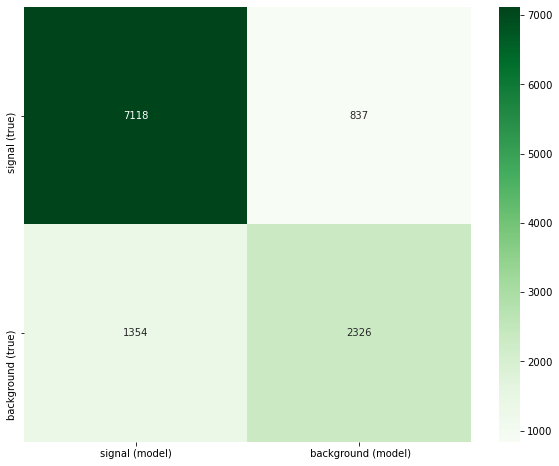

In [21]:
y_pred = model_jets_0.predict(jets_0_test_sc)
confmat = confusion_matrix(Y_0_test, np.argmax(y_pred, axis=1), labels = [0,1])
cm = pd.DataFrame(confmat,
                  index = ['signal (true)' , 'background (true)'], 
                  columns = ['signal (model)', ' background (model)'])
plt.figure(figsize=[10,8])
sns.heatmap(cm, cmap='Greens', linecolor = 'black', annot = True, fmt='d')

Epoch 1/25
2187/2187 [==============================] - 5s 2ms/step - loss: 0.4766 - accuracy: 0.7706
Epoch 2/25
2187/2187 [==============================] - 5s 2ms/step - loss: 0.4207 - accuracy: 0.8068
Epoch 3/25
2187/2187 [==============================] - 4s 2ms/step - loss: 0.4179 - accuracy: 0.8079
Epoch 4/25
2187/2187 [==============================] - 4s 2ms/step - loss: 0.4120 - accuracy: 0.8121
Epoch 5/25
2187/2187 [==============================] - 4s 2ms/step - loss: 0.4145 - accuracy: 0.8085
Epoch 6/25
2187/2187 [==============================] - 5s 2ms/step - loss: 0.4094 - accuracy: 0.8103: 0s - loss: 0.4094 - 
Epoch 7/25
2187/2187 [==============================] - 5s 2ms/step - loss: 0.4054 - accuracy: 0.8137
Epoch 8/25
2187/2187 [==============================] - 6s 3ms/step - loss: 0.4034 - accuracy: 0.8138
Epoch 9/25
2187/2187 [==============================] - 6s 3ms/step - loss: 0.4037 - accuracy: 0.8148
Epoch 10/25
2187/2187 [==============================] - 5s 

<AxesSubplot:>

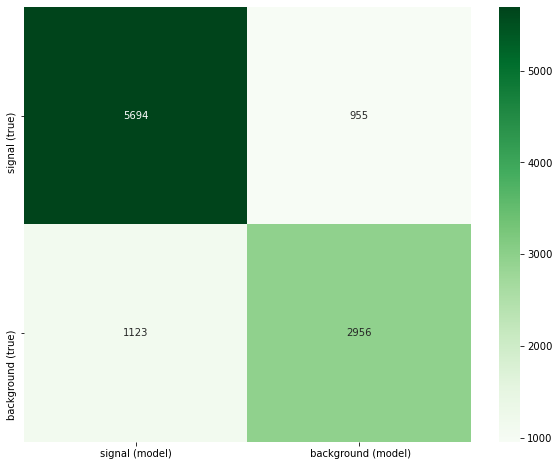

In [22]:
model_jets_1.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #binary_crossentropy
                  metrics=['accuracy'])

model_jets_1.fit(jets_1_train_sc, Y_1_train,epochs=25, batch_size=32)

# The epochs represent the number of times the model goes throught the whole dataset
# The batch size is a number of samples processed before the model is updated.


# evaluate the keras model
_, accuracy = model_jets_1.evaluate(jets_1_test_sc, Y_1_test)
print('\n')
print('Accuracy: %.2f' % (accuracy*100))

y_pred = model_jets_1.predict(jets_1_test_sc)
confmat = confusion_matrix(Y_1_test, np.argmax(y_pred, axis=1), labels = [0,1])
cm = pd.DataFrame(confmat,
                  index = ['signal (true)' , 'background (true)'], 
                  columns = ['signal (model)', ' background (model)'])
plt.figure(figsize=[10,8])
sns.heatmap(cm, cmap='Greens', linecolor = 'black', annot = True, fmt='d')

Epoch 1/25
1483/1483 [==============================] - 3s 2ms/step - loss: 0.4387 - accuracy: 0.7926
Epoch 2/25
1483/1483 [==============================] - 3s 2ms/step - loss: 0.3602 - accuracy: 0.8394
Epoch 3/25
1483/1483 [==============================] - 3s 2ms/step - loss: 0.3487 - accuracy: 0.8452
Epoch 4/25
1483/1483 [==============================] - 3s 2ms/step - loss: 0.3430 - accuracy: 0.8478: 0s - loss: 0.3
Epoch 5/25
1483/1483 [==============================] - 3s 2ms/step - loss: 0.3347 - accuracy: 0.8520
Epoch 6/25
1483/1483 [==============================] - 4s 2ms/step - loss: 0.3344 - accuracy: 0.8532
Epoch 7/25
1483/1483 [==============================] - 3s 2ms/step - loss: 0.3342 - accuracy: 0.8538
Epoch 8/25
1483/1483 [==============================] - 3s 2ms/step - loss: 0.3286 - accuracy: 0.8560
Epoch 9/25
1483/1483 [==============================] - 3s 2ms/step - loss: 0.3239 - accuracy: 0.8558
Epoch 10/25
1483/1483 [==============================] - 3s 2ms/st

<AxesSubplot:>

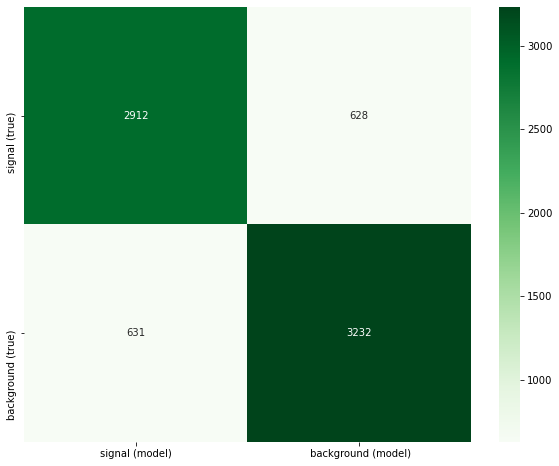

In [23]:
model_jets_2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #binary_crossentropy
                  metrics=['accuracy'])

model_jets_2.fit(jets_2_train_sc, Y_2_train,epochs=25, batch_size=32)

# The epochs represent the number of times the model goes throught the whole dataset
# The batch size is a number of samples processed before the model is updated.


# evaluate the keras model
_, accuracy = model_jets_2.evaluate(jets_2_test_sc, Y_2_test)
print('\n')
print('Accuracy: %.2f' % (accuracy*100))

y_pred = model_jets_2.predict(jets_2_test_sc)
confmat = confusion_matrix(Y_2_test, np.argmax(y_pred, axis=1), labels = [0,1])
cm = pd.DataFrame(confmat,
                  index = ['signal (true)' , 'background (true)'], 
                  columns = ['signal (model)', ' background (model)'])
plt.figure(figsize=[10,8])
sns.heatmap(cm, cmap='Greens', linecolor = 'black', annot = True, fmt='d')

Epoch 1/25
647/647 [==============================] - 3s 4ms/step - loss: 0.5055 - accuracy: 0.7504
Epoch 2/25
647/647 [==============================] - 2s 3ms/step - loss: 0.3941 - accuracy: 0.8297
Epoch 3/25
647/647 [==============================] - 1s 2ms/step - loss: 0.3792 - accuracy: 0.8330
Epoch 4/25
647/647 [==============================] - 2s 2ms/step - loss: 0.3639 - accuracy: 0.8462
Epoch 5/25
647/647 [==============================] - 2s 4ms/step - loss: 0.3516 - accuracy: 0.8482
Epoch 6/25
647/647 [==============================] - 1s 2ms/step - loss: 0.3535 - accuracy: 0.8476
Epoch 7/25
647/647 [==============================] - 1s 2ms/step - loss: 0.3461 - accuracy: 0.8506: 0s - loss: 0
Epoch 8/25
647/647 [==============================] - 1s 2ms/step - loss: 0.3470 - accuracy: 0.8497
Epoch 9/25
647/647 [==============================] - 1s 2ms/step - loss: 0.3372 - accuracy: 0.8566
Epoch 10/25
647/647 [==============================] - 1s 2ms/step - loss: 0.3290 - ac

<AxesSubplot:>

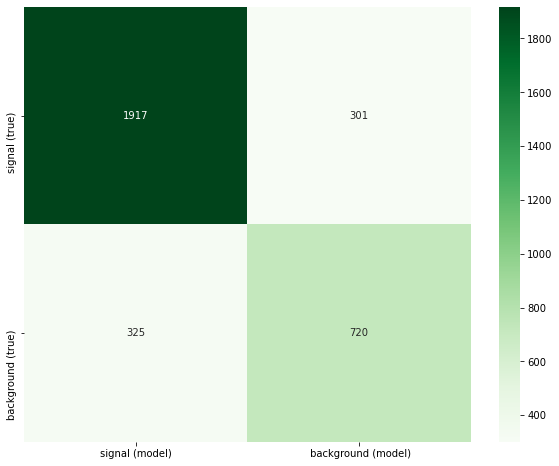

In [24]:
model_jets_3.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #binary_crossentropy
                  metrics=['accuracy'])

model_jets_3.fit(jets_3_train_sc, Y_3_train,epochs=25, batch_size=32)

# The epochs represent the number of times the model goes throught the whole dataset
# The batch size is a number of samples processed before the model is updated.


# evaluate the keras model
_, accuracy = model_jets_3.evaluate(jets_3_test_sc, Y_3_test)
print('\n')
print('Accuracy: %.2f' % (accuracy*100))

y_pred = model_jets_3.predict(jets_3_test_sc)
confmat = confusion_matrix(Y_3_test, np.argmax(y_pred, axis=1), labels = [0,1])
cm = pd.DataFrame(confmat,
                  index = ['signal (true)' , 'background (true)'], 
                  columns = ['signal (model)', ' background (model)'])
plt.figure(figsize=[10,8])
sns.heatmap(cm, cmap='Greens', linecolor = 'black', annot = True, fmt='d')

### b) Let's now analyze the data set where the unphysical values are substituted by the most frequent value in each feature

In [25]:
# dataset
mfrequent = pd.read_csv('DataFiles/most_frequent_data.csv')

twodrop = ['EventId','Weight','KaggleWeight', 'PRI_jet_leading_phi', 'PRI_jet_subleading_phi', 'PRI_met_phi', 'PRI_lep_phi', 'PRI_tau_phi' ]

#Dropping spoureous and unphysical variables
m_frequent=mfrequent.drop(twodrop,axis=1)

m_frequent.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_all_pt,Label,KaggleSet
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,16.824,258.733,2,67.435,2.150,46.062,1.240,113.497,s,t
1,160.937,68.768,103.235,48.146,0.377,95.910,-0.000,3.473,2.078,125.157,...,44.704,164.546,1,46.226,0.725,30.256,-1.699,46.226,b,t
2,110.070,162.172,125.953,35.635,0.377,95.910,-0.000,3.148,9.336,197.814,...,54.283,260.414,1,44.251,2.053,30.256,-1.699,44.251,b,t
3,143.905,81.417,80.943,0.414,0.377,95.910,-0.000,3.310,0.414,75.968,...,31.082,86.062,0,30.746,-1.507,30.256,-1.699,-0.000,b,t
4,175.864,16.915,134.805,16.405,0.377,95.910,-0.000,3.891,16.405,57.983,...,2.723,53.131,0,30.746,-1.507,30.256,-1.699,0.000,b,t


In [26]:
newjets_0 = m_frequent[m_frequent['PRI_jet_num']==0]
newjets_1 = m_frequent[m_frequent['PRI_jet_num']==1]
newjets_2 = m_frequent[m_frequent['PRI_jet_num']==2]
newjets_3 = m_frequent[m_frequent['PRI_jet_num']==3]

newjets_0.shape, newjets_1.shape, newjets_2.shape, newjets_3.shape

((327371, 27), (252882, 27), (165027, 27), (72958, 27))

This data set doesn't have any -999 values since they were replaced by the most frequent value in each colum

In [27]:
for jet, cur_set in enumerate([newjets_0, newjets_1, newjets_2, newjets_3]):
    print("\n")
    print("Features in the dataset with jet=", jet, "that have a NaN value")
    print("\n")
    for col in range(len(cur_set.columns)):
        print("{:<30s}{:>4d}".format(m_frequent.columns[col],np.sum(cur_set.iloc[:, col] == -999)))



Features in the dataset with jet= 0 that have a NaN value


DER_mass_MMC                     0
DER_mass_transverse_met_lep      0
DER_mass_vis                     0
DER_pt_h                         0
DER_deltaeta_jet_jet             0
DER_mass_jet_jet                 0
DER_prodeta_jet_jet              0
DER_deltar_tau_lep               0
DER_pt_tot                       0
DER_sum_pt                       0
DER_pt_ratio_lep_tau             0
DER_met_phi_centrality           0
DER_lep_eta_centrality           0
PRI_tau_pt                       0
PRI_tau_eta                      0
PRI_lep_pt                       0
PRI_lep_eta                      0
PRI_met                          0
PRI_met_sumet                    0
PRI_jet_num                      0
PRI_jet_leading_pt               0
PRI_jet_leading_eta              0
PRI_jet_subleading_pt            0
PRI_jet_subleading_eta           0
PRI_jet_all_pt                   0
Label                            0
KaggleSet                   

As before, let's create the test and training arrays for each jet and remove the labels.

In [28]:
newjets_0_train = newjets_0[newjets_0['KaggleSet']=='t']
newjets_0_test = newjets_0[newjets_0['KaggleSet']=='b']
newjets_1_train = newjets_1[newjets_1['KaggleSet']=='t']
newjets_1_test = newjets_1[newjets_1['KaggleSet']=='b']

newjets_2_train = newjets_2[newjets_2['KaggleSet']=='t']
newjets_2_test = newjets_2[newjets_2['KaggleSet']=='b']

newjets_3_train = newjets_3[newjets_3['KaggleSet']=='t']
newjets_3_test = newjets_3[newjets_3['KaggleSet']=='b']

In [29]:
newY_0_train = bs_bool(np.array(newjets_0_train['Label']))
newY_0_test = bs_bool(np.array(newjets_0_test['Label']))

newY_1_train = bs_bool(np.array(newjets_1_train['Label']))
newY_1_test = bs_bool(np.array(newjets_1_test['Label']))

newY_2_train = bs_bool(np.array(newjets_2_train['Label']))
newY_2_test = bs_bool(np.array(newjets_2_test['Label']))

newY_3_train = bs_bool(np.array(newjets_3_train['Label']))
newY_3_test = bs_bool(np.array(newjets_3_test['Label']))

In [30]:
newjets_0_train = np.array(newjets_0_train.drop(['Label','KaggleSet'], axis=1))
newjets_0_test = np.array(newjets_0_test.drop(['Label','KaggleSet'], axis=1))

newjets_1_train = np.array(newjets_1_train.drop(['Label','KaggleSet'], axis=1))
newjets_1_test = np.array(newjets_1_test.drop(['Label','KaggleSet'], axis=1))

newjets_2_train = np.array(newjets_2_train.drop(['Label','KaggleSet'], axis=1))
newjets_2_test = np.array(newjets_2_test.drop(['Label','KaggleSet'], axis=1))

newjets_3_train = np.array(newjets_3_train.drop(['Label','KaggleSet'], axis=1))
newjets_3_test = np.array(newjets_3_test.drop(['Label','KaggleSet'], axis=1))

Let's create our neural networks for this new data set

In [31]:
scaler = StandardScaler() 

scaler.fit(newjets_0_train)
newjets_0_train_sc = scaler.transform(newjets_0_train)
newjets_0_test_sc=scaler.transform(newjets_0_test)

scaler.fit(newjets_1_train)
newjets_1_train_sc = scaler.transform(newjets_1_train)
newjets_1_test_sc=scaler.transform(newjets_1_test)

scaler.fit(newjets_2_train)
newjets_2_train_sc = scaler.transform(newjets_2_train)
newjets_2_test_sc=scaler.transform(newjets_2_test)

scaler.fit(newjets_3_train)
newjets_3_train_sc = scaler.transform(newjets_3_train)
newjets_3_test_sc=scaler.transform(newjets_3_test)

In [32]:
newmodel_jets_0 = tf.keras.Sequential([
        keras.layers.Dense(units=30, input_shape=(len(newjets_0_train_sc[0]),), activation='relu'), #units corresponds to the number of nodes
        keras.layers.Dense(units=1200, activation='relu'),
        keras.layers.Dense(units=200, activation='relu'),
        keras.layers.Dense(units=20, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax') #2 since we have two posssible outcomes
    ])

newmodel_jets_1 = tf.keras.Sequential([
        keras.layers.Dense(units=30, input_shape=(len(newjets_1_train_sc[0]),), activation='relu'), 
        keras.layers.Dense(units=1200, activation='relu'),
        keras.layers.Dense(units=200, activation='relu'),
        keras.layers.Dense(units=20, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax') 
    ])

newmodel_jets_2 = tf.keras.Sequential([
        keras.layers.Dense(units=30, input_shape=(len(newjets_2_train_sc[0]),), activation='relu'), 
        keras.layers.Dense(units=1200, activation='relu'),
        keras.layers.Dense(units=200, activation='relu'),
        keras.layers.Dense(units=20, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax') 
    ])

newmodel_jets_3 = tf.keras.Sequential([
        keras.layers.Dense(units=30, input_shape=(len(newjets_3_train_sc[0]),), activation='relu'), 
        keras.layers.Dense(units=1200, activation='relu'),
        keras.layers.Dense(units=200, activation='relu'),
        keras.layers.Dense(units=20, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax') 
    ])

newmodel_jets_0.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 30)                780       
_________________________________________________________________
dense_21 (Dense)             (None, 1200)              37200     
_________________________________________________________________
dense_22 (Dense)             (None, 200)               240200    
_________________________________________________________________
dense_23 (Dense)             (None, 20)                4020      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 42        
Total params: 282,242
Trainable params: 282,242
Non-trainable params: 0
_________________________________________________________________


Epoch 1/25
3123/3123 [==============================] - 6s 2ms/step - loss: 0.3698 - accuracy: 0.8368
Epoch 2/25
3123/3123 [==============================] - 6s 2ms/step - loss: 0.3428 - accuracy: 0.8489
Epoch 3/25
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3436 - accuracy: 0.8478
Epoch 4/25
3123/3123 [==============================] - 8s 2ms/step - loss: 0.3378 - accuracy: 0.8516
Epoch 5/25
3123/3123 [==============================] - 7s 2ms/step - loss: 0.3375 - accuracy: 0.8509
Epoch 6/25
3123/3123 [==============================] - 7s 2ms/step - loss: 0.3368 - accuracy: 0.8504
Epoch 7/25
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3374 - accuracy: 0.8517
Epoch 8/25
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3346 - accuracy: 0.8513
Epoch 9/25
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3338 - accuracy: 0.8525
Epoch 10/25
3123/3123 [==============================] - 7s 2ms/step - loss: 0.335

<AxesSubplot:>

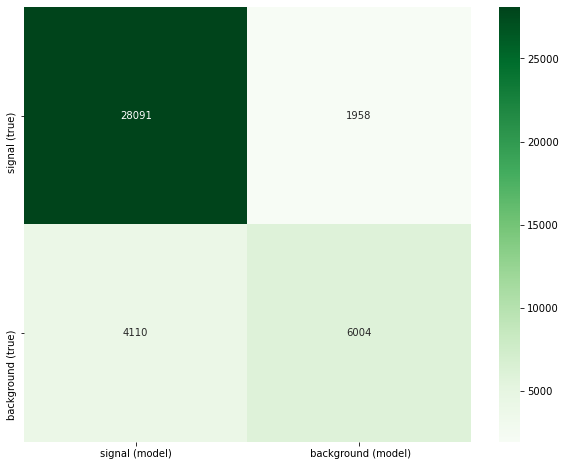

In [33]:
newmodel_jets_0.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #binary_crossentropy
                  metrics=['accuracy'])

newmodel_jets_0.fit(newjets_0_train_sc, newY_0_train,epochs=25, batch_size=32)

# The epochs represent the number of times the model goes throught the whole dataset
# The batch size is a number of samples processed before the model is updated.


# evaluate the keras model
_, accuracy = newmodel_jets_0.evaluate(newjets_0_test_sc, newY_0_test)
print('\n')
print('Accuracy: %.2f' % (accuracy*100))

y_pred = newmodel_jets_0.predict(newjets_0_test_sc)
confmat = confusion_matrix(newY_0_test, np.argmax(y_pred, axis=1), labels = [0,1])
cm = pd.DataFrame(confmat,
                  index = ['signal (true)' , 'background (true)'], 
                  columns = ['signal (model)', ' background (model)'])
plt.figure(figsize=[10,8])
sns.heatmap(cm, cmap='Greens', linecolor = 'black', annot = True, fmt='d')

Epoch 1/25
2424/2424 [==============================] - 5s 2ms/step - loss: 0.4549 - accuracy: 0.7863: 0s - loss: 0.4
Epoch 2/25
2424/2424 [==============================] - 5s 2ms/step - loss: 0.4086 - accuracy: 0.8155
Epoch 3/25
2424/2424 [==============================] - 5s 2ms/step - loss: 0.4018 - accuracy: 0.8185
Epoch 4/25
2424/2424 [==============================] - 5s 2ms/step - loss: 0.3974 - accuracy: 0.8200
Epoch 5/25
2424/2424 [==============================] - 4s 2ms/step - loss: 0.3940 - accuracy: 0.8229
Epoch 6/25
2424/2424 [==============================] - 5s 2ms/step - loss: 0.3928 - accuracy: 0.8211
Epoch 7/25
2424/2424 [==============================] - 5s 2ms/step - loss: 0.3904 - accuracy: 0.8224
Epoch 8/25
2424/2424 [==============================] - 5s 2ms/step - loss: 0.3876 - accuracy: 0.8230
Epoch 9/25
2424/2424 [==============================] - 5s 2ms/step - loss: 0.3850 - accuracy: 0.8258
Epoch 10/25
2424/2424 [==============================] - 4s 2ms/st

<AxesSubplot:>

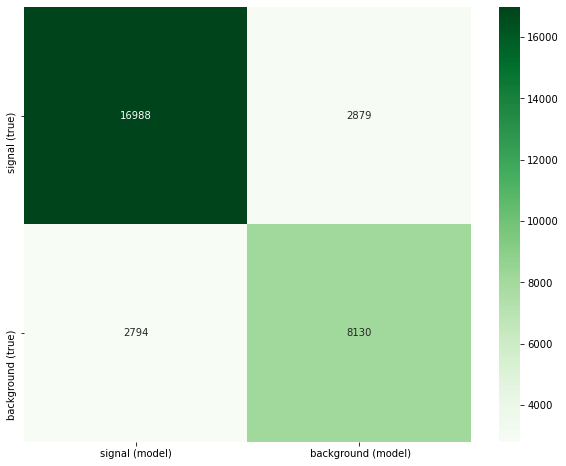

In [34]:
newmodel_jets_1.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #binary_crossentropy
                  metrics=['accuracy'])

newmodel_jets_1.fit(newjets_1_train_sc, newY_1_train,epochs=25, batch_size=32)

# The epochs represent the number of times the model goes throught the whole dataset
# The batch size is a number of samples processed before the model is updated.


# evaluate the keras model
_, accuracy = newmodel_jets_1.evaluate(newjets_1_test_sc, newY_1_test)
print('\n')
print('Accuracy: %.2f' % (accuracy*100))

y_pred = newmodel_jets_1.predict(newjets_1_test_sc)
confmat = confusion_matrix(newY_1_test, np.argmax(y_pred, axis=1), labels = [0,1])
cm = pd.DataFrame(confmat,
                  index = ['signal (true)' , 'background (true)'], 
                  columns = ['signal (model)', ' background (model)'])
plt.figure(figsize=[10,8])
sns.heatmap(cm, cmap='Greens', linecolor = 'black', annot = True, fmt='d')

Epoch 1/25
1575/1575 [==============================] - 4s 2ms/step - loss: 0.4457 - accuracy: 0.7900: 0s - loss: 0
Epoch 2/25
1575/1575 [==============================] - 3s 2ms/step - loss: 0.3549 - accuracy: 0.8463
Epoch 3/25
1575/1575 [==============================] - 3s 2ms/step - loss: 0.3464 - accuracy: 0.8490: 0s - loss: 0.3466 -  - ETA: 0s - loss: 0.3465 - accu
Epoch 4/25
1575/1575 [==============================] - 3s 2ms/step - loss: 0.3396 - accuracy: 0.8506
Epoch 5/25
1575/1575 [==============================] - 3s 2ms/step - loss: 0.3285 - accuracy: 0.8563
Epoch 6/25
1575/1575 [==============================] - 3s 2ms/step - loss: 0.3268 - accuracy: 0.8584
Epoch 7/25
1575/1575 [==============================] - 3s 2ms/step - loss: 0.3225 - accuracy: 0.8606
Epoch 8/25
1575/1575 [==============================] - 3s 2ms/step - loss: 0.3180 - accuracy: 0.8612
Epoch 9/25
1575/1575 [==============================] - 3s 2ms/step - loss: 0.3205 - accuracy: 0.8588
Epoch 10/25
15

<AxesSubplot:>

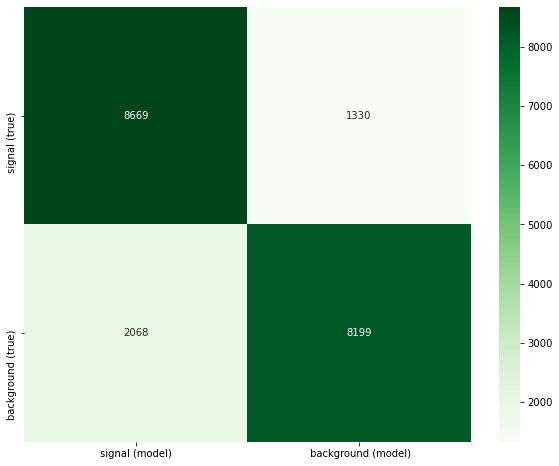

In [35]:
newmodel_jets_2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #binary_crossentropy
                  metrics=['accuracy'])

newmodel_jets_2.fit(newjets_2_train_sc, newY_2_train,epochs=25, batch_size=32)

# The epochs represent the number of times the model goes throught the whole dataset
# The batch size is a number of samples processed before the model is updated.


# evaluate the keras model
_, accuracy = newmodel_jets_2.evaluate(newjets_2_test_sc, newY_2_test)
print('\n')
print('Accuracy: %.2f' % (accuracy*100))

y_pred = newmodel_jets_2.predict(newjets_2_test_sc)
confmat = confusion_matrix(newY_2_test, np.argmax(y_pred, axis=1), labels = [0,1])
cm = pd.DataFrame(confmat,
                  index = ['signal (true)' , 'background (true)'], 
                  columns = ['signal (model)', ' background (model)'])
plt.figure(figsize=[10,8])
sns.heatmap(cm, cmap='Greens', linecolor = 'black', annot = True, fmt='d')

Epoch 1/25
693/693 [==============================] - 2s 2ms/step - loss: 0.4667 - accuracy: 0.7850
Epoch 2/25
693/693 [==============================] - 1s 2ms/step - loss: 0.3775 - accuracy: 0.8403
Epoch 3/25
693/693 [==============================] - 1s 2ms/step - loss: 0.3648 - accuracy: 0.8466
Epoch 4/25
693/693 [==============================] - 1s 2ms/step - loss: 0.3603 - accuracy: 0.8479
Epoch 5/25
693/693 [==============================] - 1s 2ms/step - loss: 0.3585 - accuracy: 0.8512
Epoch 6/25
693/693 [==============================] - 1s 2ms/step - loss: 0.3461 - accuracy: 0.8543
Epoch 7/25
693/693 [==============================] - 1s 2ms/step - loss: 0.3478 - accuracy: 0.8483
Epoch 8/25
693/693 [==============================] - 2s 2ms/step - loss: 0.3349 - accuracy: 0.8600
Epoch 9/25
693/693 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8578
Epoch 10/25
693/693 [==============================] - 1s 2ms/step - loss: 0.3262 - accuracy: 0.8594

<AxesSubplot:>

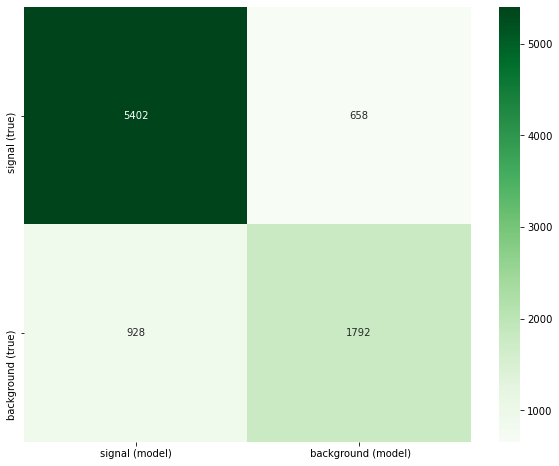

In [36]:
newmodel_jets_3.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #binary_crossentropy
                  metrics=['accuracy'])

newmodel_jets_3.fit(newjets_3_train_sc, newY_3_train,epochs=25, batch_size=32)

# The epochs represent the number of times the model goes throught the whole dataset
# The batch size is a number of samples processed before the model is updated.


# evaluate the keras model
_, accuracy = newmodel_jets_3.evaluate(newjets_3_test_sc, newY_3_test)
print('\n')
print('Accuracy: %.2f' % (accuracy*100))

y_pred = newmodel_jets_3.predict(newjets_3_test_sc)
confmat = confusion_matrix(newY_3_test, np.argmax(y_pred, axis=1), labels = [0,1])
cm = pd.DataFrame(confmat,
                  index = ['signal (true)' , 'background (true)'], 
                  columns = ['signal (model)', ' background (model)'])
plt.figure(figsize=[10,8])
sns.heatmap(cm, cmap='Greens', linecolor = 'black', annot = True, fmt='d')